# Amomaly Detection - One CLass

Part VI
## Achievement:

|Model|Precision|Recall|F1|
|-----|---------|------|--|
|Undercomplete Autoencoder|0.64|0.59|0.54|
|Denoising Autoencoder|**0.83**|**0.82**|0.82|
|local outlier factor|0.80|0.79|0.79|

### Autoencoder 
* Undercomplete Autoencoder
* Stacked Autoencoder
* Denoising Autoencoder

# 2. Dataset Preprartion 

loading the data and prepare it for the training . dataset used CICIDS-2018 

In [1]:
dataset_path = r'/media/upm/New Volume/project/0/processed'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from ml_ids.data.dataset import load_dataset
from ml_ids.transform.preprocessing import create_pipeline
from ml_ids.model_selection import split_x_y
from ml_ids.visualization import plot_confusion_matrix, plot_hist, plot_threshold
from ml_ids.keras.metrics import AveragePrecisionScoreMetric
from ml_ids.keras.callbacks import OneCycleScheduler
from ml_ids.libs.dfencoder.dataframe import EncoderDataFrame
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, mean_squared_error
from sklearn.utils.multiclass import unique_labels
from functools import partial
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers, constraints
from scipy import stats
from notebook_utils import predict, evaluate_pr_roc, plot_evaluation_curves, plot_pr_threshold_curves, best_precision_for_target_recall, print_performance, filter_benign

K = keras.backend

rand_state = 42
tf.random.set_seed(rand_state)
np.random.seed(rand_state)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline

%load_ext autoreload
%autoreload 2


Bad key "text.kerning_factor" on line 4 in
/home/upm/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## 2.1 Data loading

In [3]:
# features that will be used in the model and help for better generalization 
col_to_use = [
    'flow_duration',
    'flow_byts_s',
    'flow_pkts_s',
    'flow_iat_mean',
    'flow_iat_max',
    'flow_iat_min',
    'fwd_iat_tot',
    'fwd_iat_mean',
    'fwd_iat_max',
    'fwd_iat_min'
]

In [4]:
# values close to zero and not helping in the trainning 
no_variance = [
    "bwd_blk_rate_avg",
    "bwd_byts_b_avg",
    "bwd_pkts_b_avg",
    "bwd_psh_flags",
    "bwd_urg_flags",
    "fwd_blk_rate_avg",
    "fwd_byts_b_avg",
    "fwd_pkts_b_avg"
]

In [5]:
# features have same distrbuation for bengin and malicous trraffic 
features_same_distribution = [
    'fwd_urg_flags',
    'pkt_len_var',
    'fin_flag_cnt',
    'urg_flag_cnt',
    'cwe_flag_count',
    'down_up_ratio',
    'fwd_act_data_pkts',
    'active_max'
]

In [6]:
omit_cols = no_variance + features_same_distribution + ['timestamp', 'dst_port', 'protocol']


In [7]:
df = load_dataset(dataset_path,
                        omit_cols=omit_cols,
                        preserve_neg_value_cols = ['init_fwd_win_byts', 'init_bwd_win_byts'])

## 2.2. Dataset Split 

dataset will be split into 

* training - only benign 
* validation - both
* test - both

In [8]:
# first split the df into two datasets attack and bengin traffic 
benign = df.label_is_attack == 0
attack = df.label_cat != 0

In [9]:
# only bengin traffic for training data as normal category 
train_data, hold_data = train_test_split(df[benign], test_size=0.2, random_state=rand_state)

# 50% between test and validiation 
val_benign, test_benign = train_test_split(hold_data, test_size=0.5, random_state=rand_state)

In [10]:
# only attack data for testing and also 50 % between bengin and attack 
val_attack, test_attack = (train_test_split(df[attack],
                                                      test_size=0.5,
                                                      stratify=df[attack].label_cat,
                                                      random_state=rand_state))

In [11]:
# only benign as a raw data 
X_train_raw, y_train = split_x_y(train_data)
# both traffic in this validiation  
X_val_raw, y_val = split_x_y(val_benign.append(val_attack))
# both traffic in this test
X_test_raw, y_test = split_x_y(test_benign.append(test_attack))

<ipython-input-11-ee5d8e88723e>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_val_raw, y_val = split_x_y(val_benign.append(val_attack))
<ipython-input-11-ee5d8e88723e>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_raw, y_test = split_x_y(test_benign.append(test_attack))


In [12]:
print('Samples:')
print('========')
print('Training: {}'.format(X_train_raw.shape))
print('Val:      {}'.format(X_val_raw.shape))
print('Test:     {}'.format(X_test_raw.shape))

print('\nTraining labels:')
print('================')
print(y_train.label.value_counts())
print('\nValidation labels:')
print('==================')
print(y_val.label.value_counts())
print('\nTest labels:')
print('============')
print(y_test.label.value_counts())

del df, train_data, hold_data, val_benign, val_attack, test_benign, test_attack
gc.collect()

Samples:
Training: (10787766, 60)
Val:      (2722588, 60)
Test:     (2722589, 60)

Training labels:
Benign    10787766
Name: label, dtype: int64

Validation labels:
Benign                      1348471
DDOS attack-HOIC             343006
DDoS attacks-LOIC-HTTP       288095
DoS attacks-Hulk             230956
Bot                          143095
FTP-BruteForce                96680
SSH-Bruteforce                93794
Infilteration                 80967
DoS attacks-SlowHTTPTest      69945
DoS attacks-GoldenEye         20754
DoS attacks-Slowloris          5495
DDOS attack-LOIC-UDP            865
Brute Force -Web                306
Brute Force -XSS                115
SQL Injection                    44
Name: label, dtype: int64

Test labels:
Benign                      1348471
DDOS attack-HOIC             343006
DDoS attacks-LOIC-HTTP       288096
DoS attacks-Hulk             230956
Bot                          143096
FTP-BruteForce                96680
SSH-Bruteforce                93795
Inf

287

## 2.3 Data Preprocessing

* Missing Data Imputatioon
* Normalization using `MinMaxScaler`.

In [13]:
# create for minmaxscaler 
pipeline, get_col_names = create_pipeline(X_train_raw, 
                                          imputer_strategy='median',
                                          imputer_cols=col_to_use,
                                          scaler=MinMaxScaler)

In [14]:
X_train = pipeline.fit_transform(X_train_raw) # bengin
X_val = pipeline.transform(X_val_raw) # both
X_test = pipeline.transform(X_test_raw) #both

In [15]:
X_val_benign = filter_benign(X_val, y_val)
column_names = get_col_names()

/home/upm/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
print('Samples:')
print('========')
print('Training: {}'.format(X_train.shape))
print('Val:      {}'.format(X_val.shape))
print('Test:     {}'.format(X_test.shape))

print('\nMissing values:')
print('===============')
print('Training: {}'.format(np.count_nonzero(np.isnan(X_train))))
print('Val:      {}'.format(np.count_nonzero(np.isnan(X_val))))
print('Test:     {}'.format(np.count_nonzero(np.isnan(X_test))))

print('\nScaling:')
print('========')
print('Training: min={}, max={}'.format(np.min(X_train), np.max(X_train)))
print('Val:      min={}, max={}'.format(np.min(X_val), np.max(X_val)))
print('Test:     min={}, max={}'.format(np.min(X_test), np.max(X_test)))

Samples:
Training: (10787766, 60)
Val:      (2722588, 60)
Test:     (2722589, 60)

Missing values:
Training: 0
Val:      0
Test:     0

Scaling:
Training: min=0.0, max=1.0
Val:      min=0.0, max=2.2449962079994723
Test:     min=0.0, max=2.5524120420747187


## 3. Model Training

In this section we train and evaluate various types of autoencoder architectures to create a binary classifier using anomaly detection.

The following autoencoder architectures are evaluated:
- Undercomplete Autoencoder
- Stacked Autoencoder
- Denoising Autoencoder

In [17]:
input_dims = X_train.shape[1]
epochs = 50
batch_size = 4096

# 3.1 Undercomplete Autoencoder

The undercomplete autoencoder represents the simplest type of autoencoder, as it uses a single restricted hidden layer containing the latent representations of the data.  

In [18]:
K.clear_session()
gc.collect()

simple_ae = models.Sequential([
    layers.Dense(30, activation='elu', input_shape=[input_dims]),
    layers.Dense(input_dims, activation='sigmoid')
])

simple_ae.compile(optimizer='adam', loss='CategoricalCrossentropy')
simple_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 60)                1860      
                                                                 
Total params: 3,690
Trainable params: 3,690
Non-trainable params: 0
_________________________________________________________________


# Training Part

In [19]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

In [20]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

In [21]:
mc = callbacks.ModelCheckpoint(filepath='models/simple_autoencoder_model.h5',
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=True, 
                               verbose=0)

In [22]:

hist = simple_ae.fit(x=X_train, 
                     y=X_train, 
                     validation_data=(X_val_benign, X_val_benign),
                     batch_size=batch_size,
                     epochs=epochs,
                     callbacks=[
                         AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                         early_stopping,
                         reduce_lr,
                         mc
                     ])

Epoch 1/50
2634/2634 [==============================] - 13s 5ms/step - loss: 17.0484 - val_loss: 32.5896 - val_auprc: 0.4134 - lr: 0.0010
Epoch 2/50
2634/2634 [==============================] - 11s 4ms/step - loss: 47.0430 - val_loss: 60.8123 - val_auprc: 0.4136 - lr: 0.0010
Epoch 3/50
2634/2634 [==============================] - 11s 4ms/step - loss: 73.6197 - val_loss: 86.1172 - val_auprc: 0.4136 - lr: 0.0010
Epoch 4/50
2634/2634 [==============================] - 11s 4ms/step - loss: 98.4856 - val_loss: 110.2364 - val_auprc: 0.4146 - lr: 0.0010
Epoch 5/50
2634/2634 [==============================] - 12s 5ms/step - loss: 122.2894 - val_loss: 134.1694 - val_auprc: 0.4148 - lr: 0.0010
Epoch 6/50
2634/2634 [==============================] - 11s 4ms/step - loss: 146.2179 - val_loss: 157.0935 - val_auprc: 0.4149 - lr: 0.0010
Epoch 7/50
2634/2634 [==============================] - 11s 4ms/step - loss: 169.3105 - val_loss: 181.2699 - val_auprc: 0.4166 - lr: 0.0010
Epoch 8/50
2634/2634 [=====

# Validation 

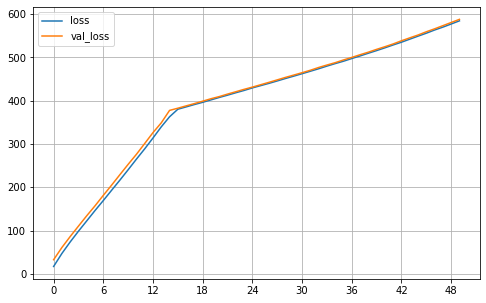

In [23]:
plot_hist(hist)

In [27]:
threshold_simple_ae = best_precision_for_target_recall(pred_val_simple_ae, target_recall=0.9)
print(threshold_simple_ae)

0.9250761806821175


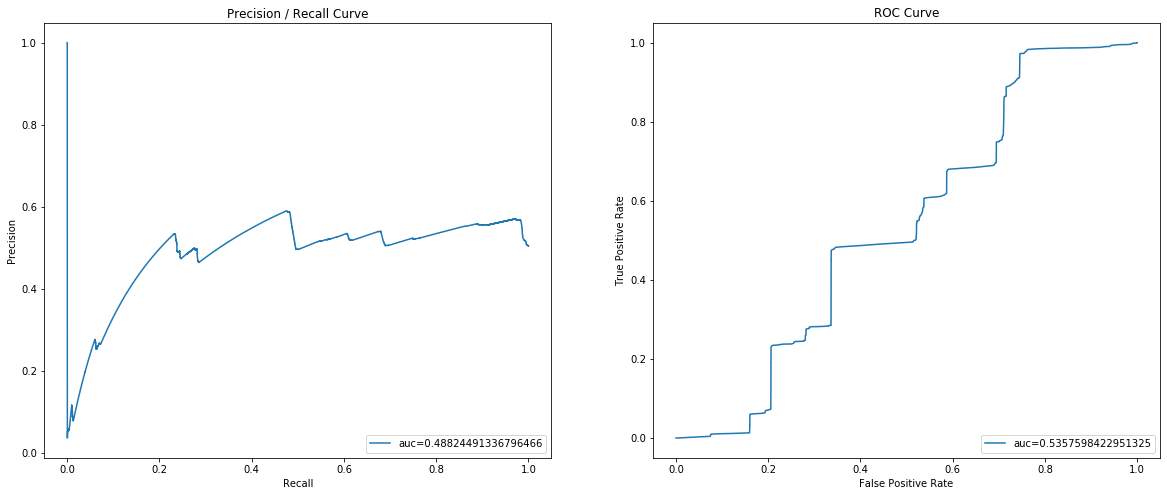

In [25]:
simple_ae = models.load_model('models/simple_autoencoder_model.h5')
#pred_train_simple_ae = predict(simple_ae, X_train, y_train.label_is_attack)
pred_val_simple_ae = predict(simple_ae, X_val, y_val.label_is_attack)

# Performance 

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.27      0.39   1348471
           1       0.56      0.90      0.69   1374117

    accuracy                           0.59   2722588
   macro avg       0.64      0.58      0.54   2722588
weighted avg       0.64      0.59      0.54   2722588

Confusion Matrix:


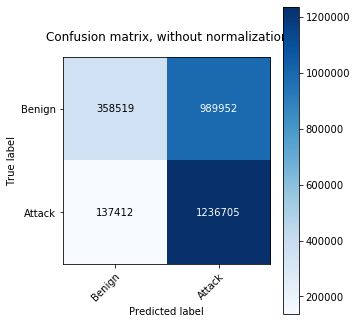

Misclassifications by attack category:


,misclassified,total,percent_misclassified
DDOS attack-LOIC-UDP,816,865,0.943353
Benign,989952,1348471,0.734129
DoS attacks-Slowloris,3978,5495,0.723931
Brute Force -XSS,63,115,0.547826
SQL Injection,19,44,0.431818
Brute Force -Web,87,306,0.284314
DDOS attack-HOIC,81817,343006,0.238529
Infilteration,15799,80967,0.195129
DDoS attacks-LOIC-HTTP,32632,288095,0.113268
DoS attacks-GoldenEye,1677,20754,0.080804


In [28]:
print_performance(y_val, pred_val_simple_ae, threshold=threshold_simple_ae)

# 3.2 Denoising Autoencoder

Another variant of the autoencoder is the denoising autoencoder. In this version, the model is restricted not by limiting the size of the hidden layers but by adding additional noise to the inputs. The objective of the model is to recreate the inputs without containing the noise.    

In [29]:
X_train_swapped = EncoderDataFrame(pd.DataFrame(data=X_train).copy()).swap(likelihood=.15).values
X_val_benign_swapped = EncoderDataFrame(pd.DataFrame(data=X_val_benign).copy()).swap(likelihood=.15).values

In [30]:
K.clear_session()
gc.collect()

activation = 'elu' 
dropout = 0.1

denoising_ae = models.Sequential([
    layers.Dense(512, activation=activation, input_shape=[input_dims]),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(512, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(input_dims, activation='sigmoid')
])

denoising_ae.compile(optimizer='adam', loss='binary_crossentropy')
denoising_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               31232     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               2

# Training 

In [31]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/denoising_autoencoder_model.h5', 
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=True, 
                               verbose=0)

hist = denoising_ae.fit(x=X_train_swapped, 
                        y=X_train, 
                        validation_data=(X_val_benign_swapped, X_val_benign),
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=[
                            AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                            early_stopping,
                            reduce_lr,
                            mc
                        ])

Epoch 1/50
2634/2634 [==============================] - 26s 9ms/step - loss: 0.0380 - val_loss: 0.0341 - val_auprc: 0.8805 - lr: 0.0010
Epoch 2/50
2634/2634 [==============================] - 25s 9ms/step - loss: 0.0341 - val_loss: 0.0334 - val_auprc: 0.8648 - lr: 0.0010
Epoch 3/50
2634/2634 [==============================] - 25s 9ms/step - loss: 0.0336 - val_loss: 0.0331 - val_auprc: 0.8948 - lr: 0.0010
Epoch 4/50
2634/2634 [==============================] - 25s 9ms/step - loss: 0.0333 - val_loss: 0.0329 - val_auprc: 0.8832 - lr: 0.0010
Epoch 5/50
2634/2634 [==============================] - 25s 10ms/step - loss: 0.0331 - val_loss: 0.0328 - val_auprc: 0.9028 - lr: 0.0010
Epoch 6/50
2634/2634 [==============================] - 25s 9ms/step - loss: 0.0330 - val_loss: 0.0327 - val_auprc: 0.8768 - lr: 0.0010
Epoch 7/50
2634/2634 [==============================] - 25s 9ms/step - loss: 0.0329 - val_loss: 0.0326 - val_auprc: 0.8740 - lr: 0.0010
Epoch 8/50
2634/2634 [=========================

# Validation

The learning curves suggest that the model does not overfit the training data. As we use `Dropout` layers the validation loss is lower than the training loss.

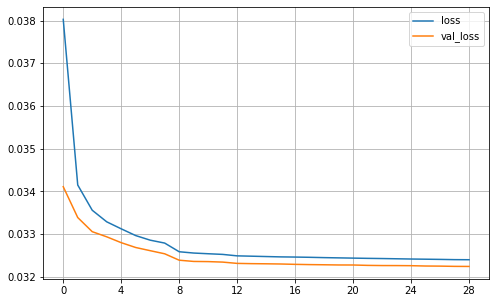

In [32]:
plot_hist(hist)

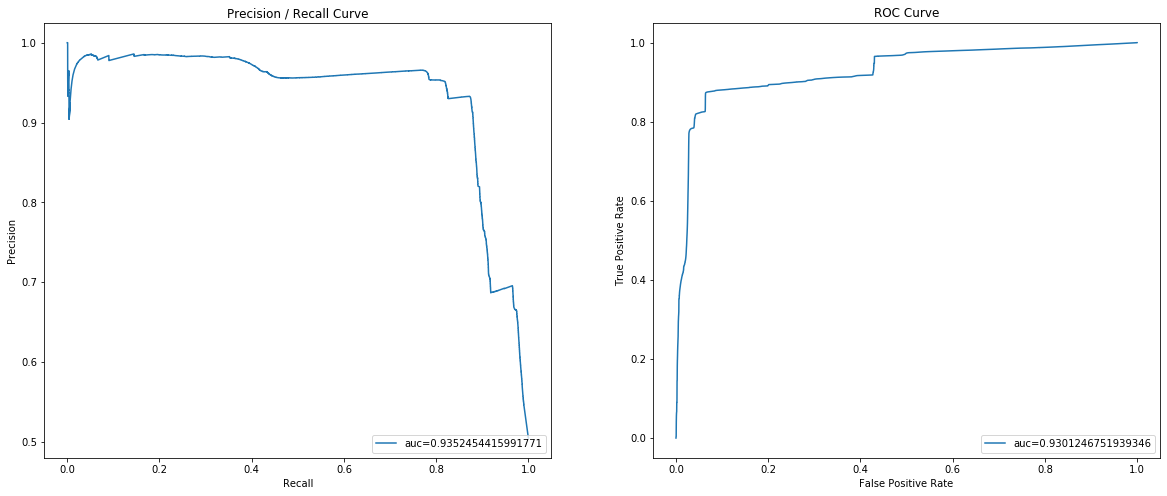

In [34]:
denoising_ae = models.load_model('models/denoising_autoencoder_model.h5')
#pred_train_denoising_ae = predict(denoising_ae, X_train, y_train.label_is_attack)
pred_val_denoising_ae = predict(denoising_ae, X_val, y_val.label_is_attack)


In [36]:
threshold_denoising_ae = best_precision_for_target_recall(pred_val_denoising_ae, target_recall=0.9)
print(threshold_denoising_ae)

3.3775885543509273e-06


# Performance

The performance of the denoising autoencoder surpasses the performance of the other models.

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81   1348471
           1       0.78      0.90      0.84   1374117

    accuracy                           0.82   2722588
   macro avg       0.83      0.82      0.82   2722588
weighted avg       0.83      0.82      0.82   2722588

Confusion Matrix:


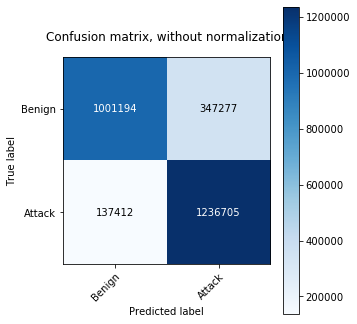

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,55519,80967,0.685699
Bot,72027,143095,0.503351
Brute Force -XSS,49,115,0.426087
Brute Force -Web,96,306,0.313725
SQL Injection,13,44,0.295455
Benign,347277,1348471,0.257534
DDoS attacks-LOIC-HTTP,9707,288095,0.033694
DoS attacks-GoldenEye,1,20754,0.000048


In [39]:
print_performance(y_val, pred_val_denoising_ae, threshold=threshold_denoising_ae)

## 3.3 Stacked Autoencoder


**Note**

The main idea of the stacked autoencoder is to modify an undercomplete autoencoder by adding additional hidden layers, transforming the undercomplete autoencoder into a deep learning model. Adding more layers allows the autoencoder to create more complex representations, which can enhance performance. However, one has to pay attention not to make the autoencoder too powerfull as it might simply recreate the outputs by copying the given inputs if possible.  

In [40]:
# creating a new hidden layers 
K.clear_session()
gc.collect()

activation = 'elu'
dropout= 0.1

stacked_ae = models.Sequential([
    layers.Dense(50, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0), input_shape=(input_dims,)),
    layers.Dense(30, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(20, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(10, activation=activation, kernel_constraint=constraints.UnitNorm(axis=0)),
    layers.Dense(20, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(30, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(50, activation=activation),
    layers.Dropout(dropout),
    layers.Dense(input_dims, activation='sigmoid')
])

stacked_ae.compile(optimizer='adam', loss='binary_crossentropy')
stacked_ae.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                3050      
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 20)                620       
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
 dense_4 (Dense)             (None, 20)                220       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 30)                6

# Training 

In [41]:
early_stopping = callbacks.EarlyStopping(monitor='val_auprc', 
                                         mode='max',
                                         patience=15,                             
                                         restore_best_weights=True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_auprc', 
                                        mode='max', 
                                        factor=0.2, 
                                        patience=3, 
                                        min_lr=0.0001)

mc = callbacks.ModelCheckpoint(filepath='models/stacked_autoencoder_model.h5',
                               monitor='val_auprc', 
                               mode='max',
                               save_best_only=True, 
                               verbose=0)

hist = stacked_ae.fit(x=X_train, 
                      y=X_train, 
                      validation_data=(X_val_benign, X_val_benign),
                      batch_size=batch_size,
                      epochs=epochs,
                      callbacks=[
                          AveragePrecisionScoreMetric(X_val=X_val, y_val=y_val.label_is_attack, batch_size=16384),
                          early_stopping,
                          reduce_lr,
                          mc
                      ])

Epoch 1/50
2634/2634 [==============================] - 15s 5ms/step - loss: 0.0514 - val_loss: 0.0327 - val_auprc: 0.8020 - lr: 0.0010
Epoch 2/50
2634/2634 [==============================] - 16s 6ms/step - loss: 0.0336 - val_loss: 0.0318 - val_auprc: 0.7983 - lr: 0.0010
Epoch 3/50
2634/2634 [==============================] - 16s 6ms/step - loss: 0.0327 - val_loss: 0.0314 - val_auprc: 0.7812 - lr: 0.0010
Epoch 4/50
2634/2634 [==============================] - 16s 6ms/step - loss: 0.0323 - val_loss: 0.0313 - val_auprc: 0.8051 - lr: 0.0010
Epoch 5/50
2634/2634 [==============================] - 14s 5ms/step - loss: 0.0320 - val_loss: 0.0312 - val_auprc: 0.8537 - lr: 0.0010
Epoch 6/50
2634/2634 [==============================] - 15s 6ms/step - loss: 0.0319 - val_loss: 0.0311 - val_auprc: 0.8758 - lr: 0.0010
Epoch 7/50
2634/2634 [==============================] - 16s 6ms/step - loss: 0.0318 - val_loss: 0.0311 - val_auprc: 0.8577 - lr: 0.0010
Epoch 8/50
2634/2634 [==========================

# Validation

The learning curves suggest that the model does not overfit the training data. As we use `Dropout` layers, the validation loss is lower than the training loss.

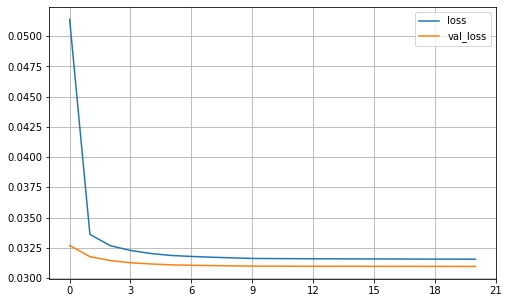

In [46]:
plot_hist(hist)

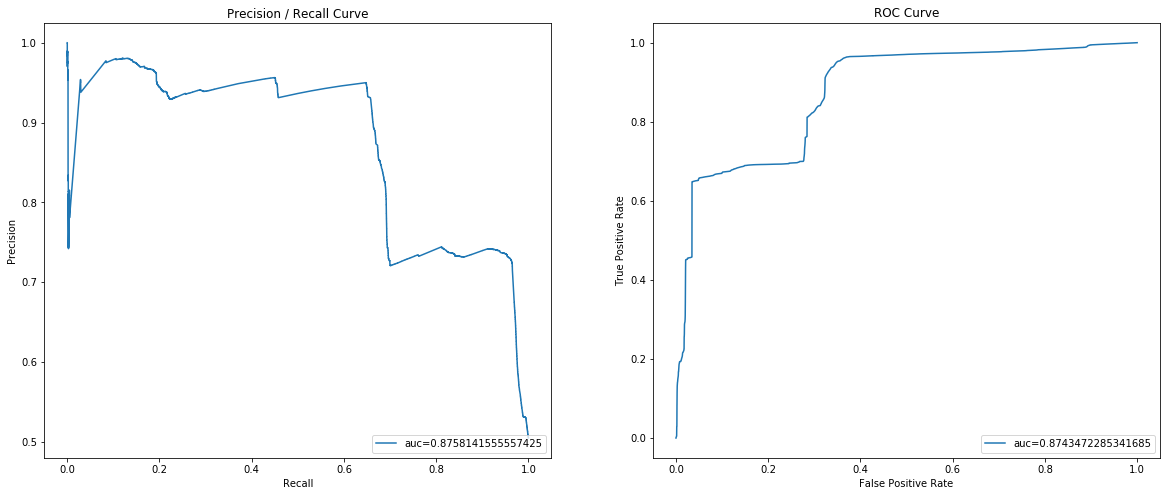

In [42]:
stacked_ae = models.load_model('models/stacked_autoencoder_model.h5')
#pred_train_stacked_ae = predict(stacked_ae, X_train, y_train.label_is_attack)
pred_val_stacked_ae = predict(stacked_ae, X_val, y_val.label_is_attack)



In [44]:
threshold_stacked_ae = best_precision_for_target_recall(pred_val_stacked_ae, target_recall=0.9)
print(threshold_stacked_ae)

9.894460564532637e-06


# Performance

The performance of the stacked autoencoder was better than the performance of the undercomplete autoencoder.

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.68      0.76   1348471
           1       0.74      0.90      0.81   1374117

    accuracy                           0.79   2722588
   macro avg       0.80      0.79      0.79   2722588
weighted avg       0.80      0.79      0.79   2722588

Confusion Matrix:


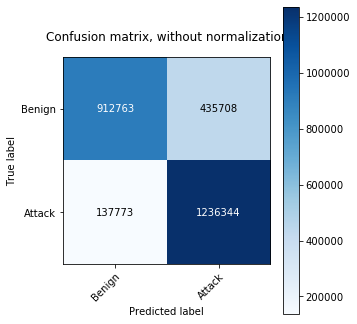

Misclassifications by attack category:


,misclassified,total,percent_misclassified
Infilteration,43741,80967,0.540232
Benign,435708,1348471,0.323113
Brute Force -XSS,36,115,0.313043
DDoS attacks-LOIC-HTTP,71006,288095,0.246467
Brute Force -Web,56,306,0.183007
SQL Injection,8,44,0.181818
Bot,22924,143095,0.160201
DDOS attack-LOIC-UDP,1,865,0.001156
DoS attacks-GoldenEye,1,20754,0.000048


In [45]:
print_performance(y_val, pred_val_stacked_ae, threshold=threshold_stacked_ae)

# Lessons Learned 


in terms of this problem and the provided data tells us that Anamoly detection methods wasnt the best option for real live implmentation , surpisinglny the classical machine learning models in the pervoius expermints out perform the 3 vations of autoencoder nearual network . However, the best advatantge of this process is that anamoly detection can take only one class/label during the training which is a very good option in the absence of malicous network traffic during the training phase .